In [2]:
import pandas as pd
from darts import TimeSeries
from darts.models import LinearRegressionModel
from darts.metrics import mape, rmse
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
data = pd.read_parquet("../data/afrr_price.parquet")

In [4]:
data["prod_unbalance"] = data[["wind_offshore_dayahead", "wind_onshore_dayahead", "solar_dayahead"]].sum(axis=1) - data["load_forecasts"]

In [5]:
data = data[['wind_offshore_dayahead', 'wind_onshore_dayahead',
       'solar_dayahead','aFRR_DownCapPriceEUR', 'aFRR_UpCapPriceEUR', 'load_forecasts',
       'da_price', 'prod_unbalance']]

In [6]:
data = data.dropna()

In [7]:
#data = data.rolling(10).mean()

In [8]:
#data["aFRR_UpCapPriceEUR"] = data["aFRR_UpCapPriceEUR"].diff(24)

In [9]:
#data = data.diff(1).dropna()

In [31]:
import pandas as pd
import numpy as np
from darts import TimeSeries
from darts.models import LinearRegressionModel
from darts.dataprocessing.transformers import Scaler
from darts.utils.missing_values import extract_subseries
import matplotlib.pyplot as plt

# Define target and exogenous variables
target_col = 'aFRR_UpCapPriceEUR'
exog_cols = ['wind_offshore_dayahead', 'wind_onshore_dayahead', 
             'solar_dayahead']

# Create TimeSeries objects
target_series = TimeSeries.from_series(data[target_col], freq="1h")
covariates = TimeSeries.from_dataframe(data[exog_cols], freq="1h")

# Extract subseries without missing values
target_subseries = extract_subseries(
    series=target_series,
    min_gap_size=1
)

covariates_subseries = extract_subseries(
    series=covariates,
    min_gap_size=1,
    mode='all'
)

# Get longest clean subseries
target_clean = max(target_subseries, key=len)
covariates_clean = max(covariates_subseries, key=len)

# Find overlapping time period
start_time = max(target_clean.start_time(), covariates_clean.start_time())
end_time = min(target_clean.end_time(), covariates_clean.end_time())

# Slice to common time range
target_final = target_clean.slice(start_time, end_time)
covariates_final = covariates_clean.slice(start_time, end_time)

print(f"Clean aligned series length: {len(target_final)}")

train_cutoff = int(len(target_final) * 0.5)
train_target = target_final[:train_cutoff]
test_target = target_final[train_cutoff:]

max_past_lag = 24  # Assuming your longest past lag is 24

# Train covariates should end at train_cutoff
train_covariates = covariates_final[:train_cutoff]

# Test covariates should include some history before test period starts
# This creates an overlap between train and test covariates
test_covariates_start = train_cutoff - max_past_lag
test_covariates = covariates_final[test_covariates_start:]

# Scale the data
scaler_target = Scaler()
scaler_covariates = Scaler()
train_target_scaled = scaler_target.fit_transform(train_target)
train_covariates_scaled = scaler_covariates.fit_transform(train_covariates)
test_covariates_scaled = scaler_covariates.transform(test_covariates)
full_covariates_scaled = scaler_covariates.transform(covariates_final)

The provided DatetimeIndex was associated with a timezone, which is currently not supported by xarray. To avoid unexpected behaviour, the tz information was removed. Consider calling `ts.time_index.tz_localize(UTC)` when exporting the results.To plot the series with the right time steps, consider setting the matplotlib.pyplot `rcParams['timezone']` parameter to automatically convert the time axis back to the original timezone.
The provided DatetimeIndex was associated with a timezone, which is currently not supported by xarray. To avoid unexpected behaviour, the tz information was removed. Consider calling `ts.time_index.tz_localize(UTC)` when exporting the results.To plot the series with the right time steps, consider setting the matplotlib.pyplot `rcParams['timezone']` parameter to automatically convert the time axis back to the original timezone.


Clean aligned series length: 1223


In [40]:
from darts.models import RegressionModel
from sklearn.linear_model import Ridge

model = RegressionModel(
    lags=list(range(-1, -24, -1)), 
    lags_past_covariates=list(range(-1, -6, -1)),
    lags_future_covariates=list(range(1,10,1)),  
    output_chunk_length=24,

)


model.fit(
    series=train_target_scaled,
    future_covariates=train_covariates_scaled,
    past_covariates=train_covariates_scaled)


backtest_forecasts = model.historical_forecasts(
    series=train_target_scaled,
    past_covariates=train_covariates_scaled,
    future_covariates=full_covariates_scaled,
    start=0.1,
    forecast_horizon=24,
    stride=24,
    retrain=True,
    verbose=True
)

`enable_optimization=True` is ignored because `retrain` is not `False` or `0`. To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


historical forecasts:   0%|          | 0/22 [00:00<?, ?it/s]

<Axes: xlabel='time'>

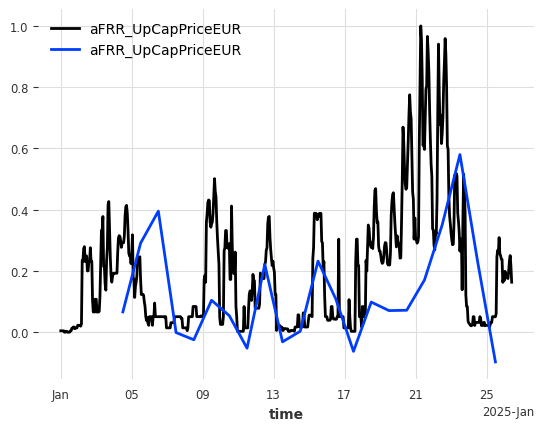

In [41]:
train_target_scaled.plot()
backtest_forecasts.plot()

In [39]:
backtest_forecasts.pd_dataframe()


component,aFRR_UpCapPriceEUR
time,
2025-01-04 12:00:00,0.066282
2025-01-05 12:00:00,0.290861
2025-01-06 12:00:00,0.395131
2025-01-07 12:00:00,-0.001308
2025-01-08 12:00:00,-0.024738
2025-01-09 12:00:00,0.104238
2025-01-10 12:00:00,0.053890
2025-01-11 12:00:00,-0.052336
2025-01-12 12:00:00,0.220930


In [ ]:
test_target_